In [1]:
import sys
sys.path.append('../../')

from tqdm import tqdm

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

from rcgp.rcgp import SpatioTemporalRCGP

from data.simulations import spatio_temporal_half_contaminated

In [2]:
def plot(idx, grid, ts, pred, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    pred = pred[idx].reshape(n_lon, n_lat)
    Ys = Ys[idx].reshape(n_lon, n_lat)
    Ys_no_outliers = Ys_no_outliers[idx].reshape(n_lon, n_lat)
    true_Ys = true_Ys[idx].reshape(n_lon, n_lat)


    fig, axs = plt.subplots(1, 3, figsize=(12,3))
    kwargs = {"levels" : 20, "cmap": "YlGnBu", "vmin" : Ys_no_outliers.min().item(), "vmax" : Ys_no_outliers.max().item()}

    outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

    axs[0].contourf(X, Y, pred, **kwargs)
    axs[1].contourf(X, Y, Ys_no_outliers, **kwargs)
    axs[1].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=30., color='red')
    axs[2].contourf(X, Y, true_Ys, **kwargs)
    
    axs[0].set_title("Prediction")
    axs[1].set_title("Data")
    axs[2].set_title("True Latent Function")

    print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())

    return

In [3]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

## Experiment : Comparing STGP vs Robust RCGP When Training on Absolute Diff Loss With Known True Function

### STGP

100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


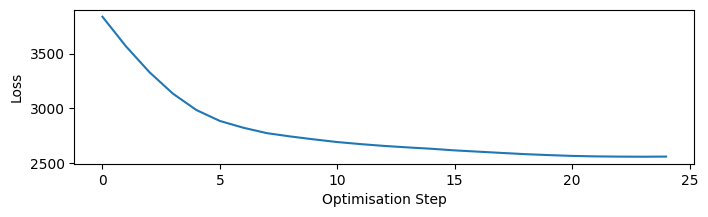

In [10]:
gp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)
gp.deactivate_robustness() #STGP

losses = []
n_steps = 25
lr = 0.2

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)

    loss = tc.abs(preds - true_Ys).sum()
    loss.backward()
    losses.append(loss.clone().detach())
    
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [11]:
print("---Likelihood Variance----")
print(gp.var_y.clone().detach().item())
print("\n----Spatial Lengthscale, Magnitude-----")
print(gp.spatial_lengthscale.clone().detach().item(), gp.spatial_magnitude.clone().detach().item())
print("\n----Temporal Lengthscale, Magnitude----")
print(gp.temporal_lengthscale.clone().detach().item(), gp.temporal_magnitude.clone().detach().item())

---Likelihood Variance----
0.6467272639274597

----Spatial Lengthscale, Magnitude-----
5.579840660095215 2.6705434322357178

----Temporal Lengthscale, Magnitude----
0.275910347700119 2.6569738388061523


Sum of Absolute Diff (pred - true) :  tensor(724.6971) 

Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  64.95759582519531
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  67.03749084472656
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  80.15977478027344
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  70.52705383300781
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  70.95829772949219
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  61.523597717285156
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  77.6702651977539
Mean Absolute Difference (Data - No Outliers) :  98.4655456

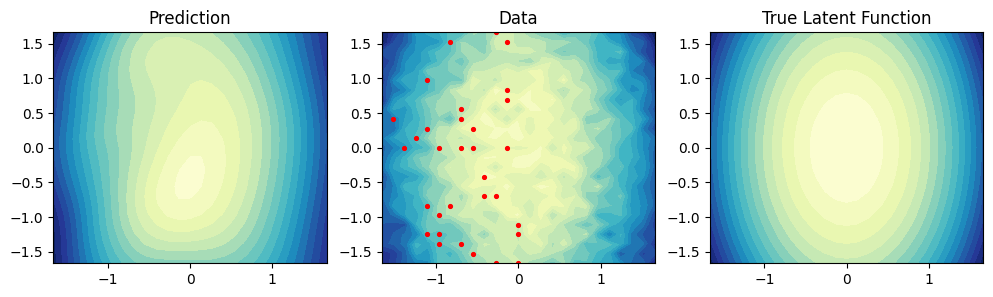

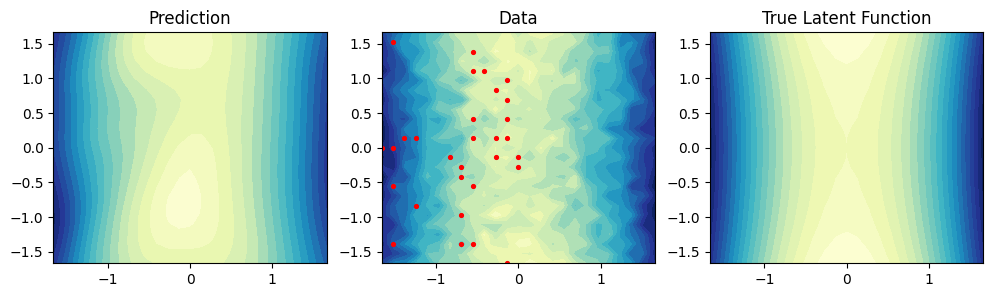

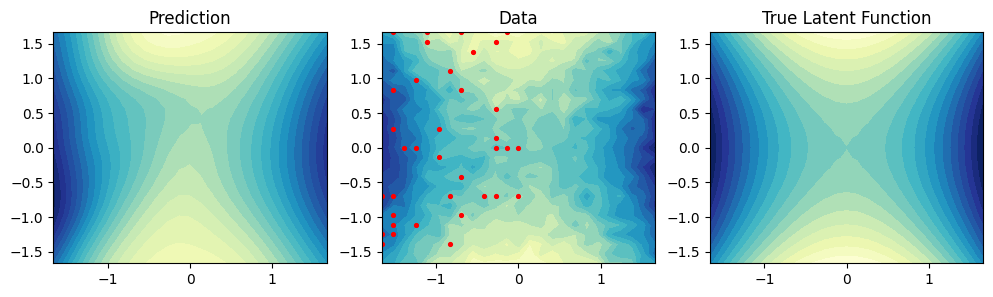

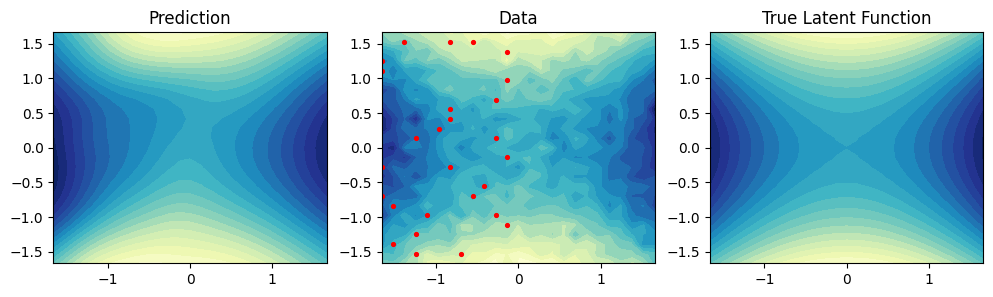

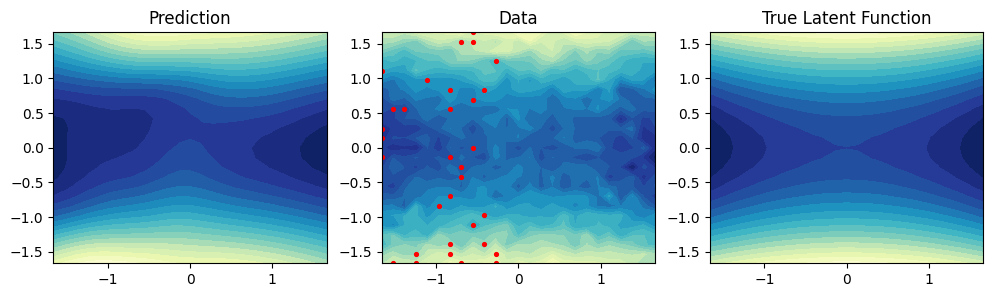

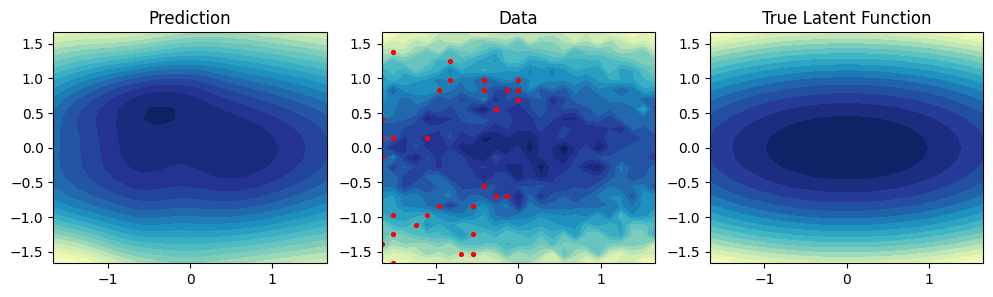

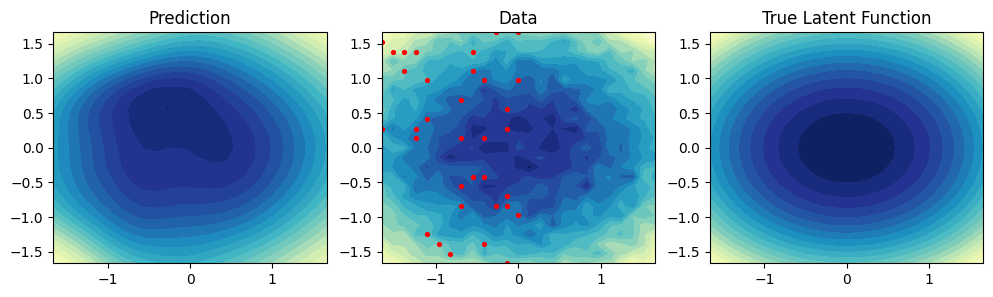

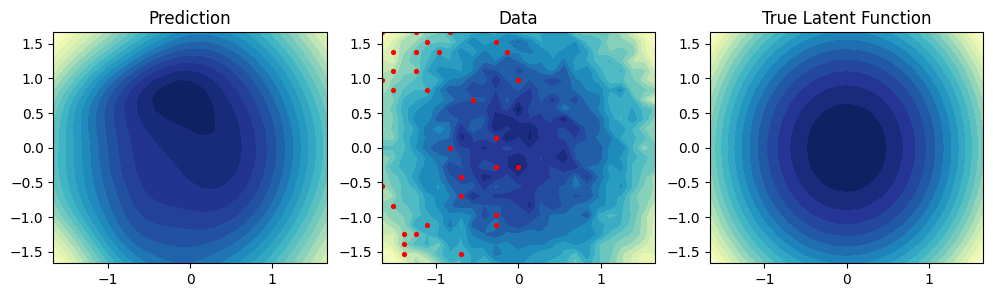

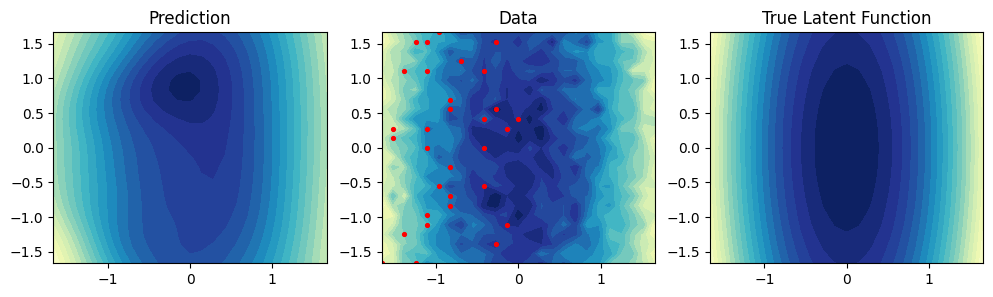

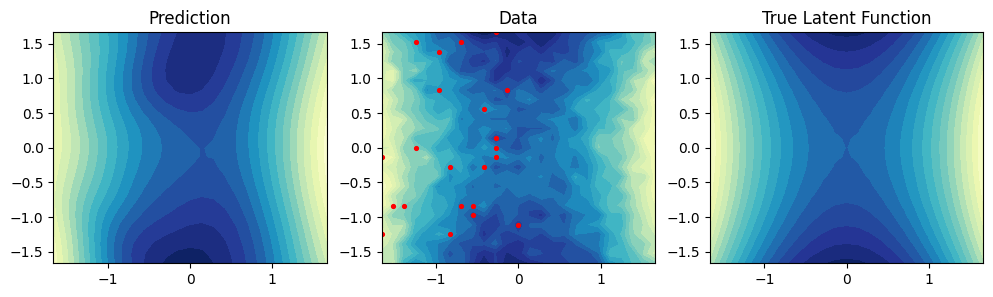

In [12]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

    print("Sum of Absolute Diff (pred - true) : ", (tc.abs(preds_smooth - true_Ys.squeeze(-1))).sum(), "\n")

for i in range(10):
    plot(idx=i, grid=grids[0], ts=ts, pred=preds_smooth, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)

### ST-RCGP (adaptive c, spatial smoothing prior mean)

100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


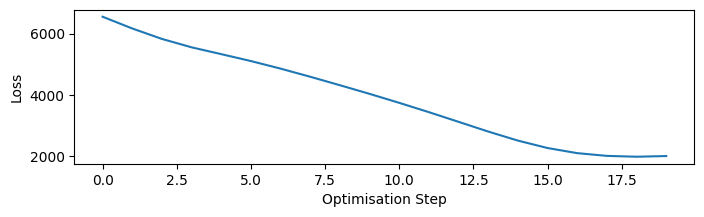

In [13]:
gp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)

gp.activate_robustness(func="local_constant") 
gp._K_w_lengthscale = 1.

gp.adaptive_c(c_factor=1.)

losses = []
n_steps = 20
lr = 0.2

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)

    loss = tc.abs(preds - true_Ys).sum()
    loss.backward()
    losses.append(loss.clone().detach())

    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [14]:
print("---Likelihood Variance----")
print(gp.var_y.clone().detach().item())
print("\n----Spatial Lengthscale, Magnitude-----")
print(gp.spatial_lengthscale.clone().detach().item(), gp.spatial_magnitude.clone().detach().item())
print("\n----Temporal Lengthscale, Magnitude----")
print(gp.temporal_lengthscale.clone().detach().item(), gp.temporal_magnitude.clone().detach().item())

---Likelihood Variance----
0.08389288187026978

----Spatial Lengthscale, Magnitude-----
2.2851011753082275 2.2612457275390625

----Temporal Lengthscale, Magnitude----
0.2608370780944824 2.2620277404785156


Sum Absolute Diff (pred - true) :  tensor(282.9984) 

Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  32.31898880004883
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  31.938016891479492
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  29.148420333862305
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  29.64821434020996
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  28.25818634033203
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  23.037317276000977
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  21.844947814941406
Mean Absolute Difference (Data - No Outliers) :  98.465545

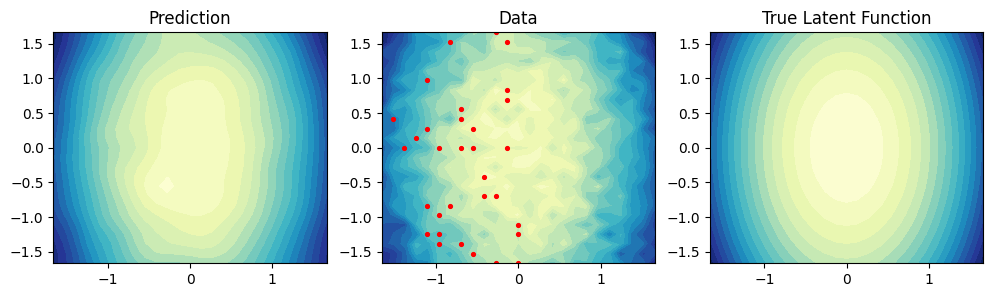

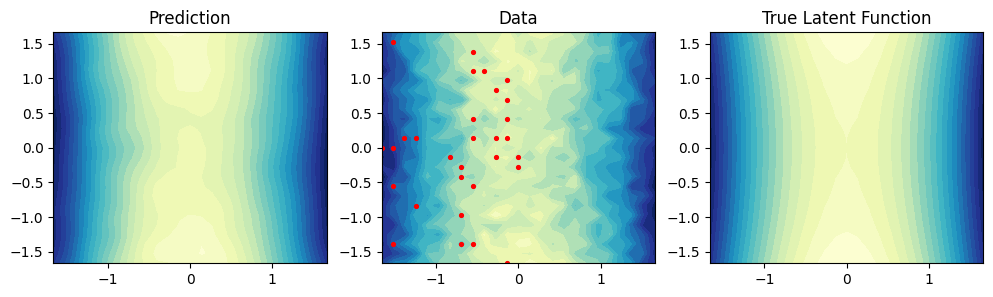

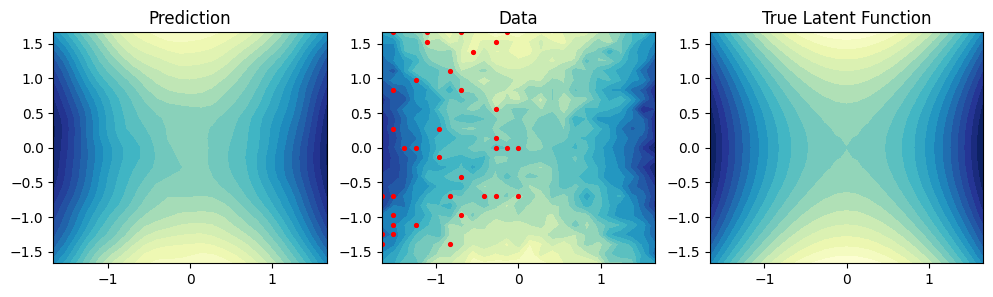

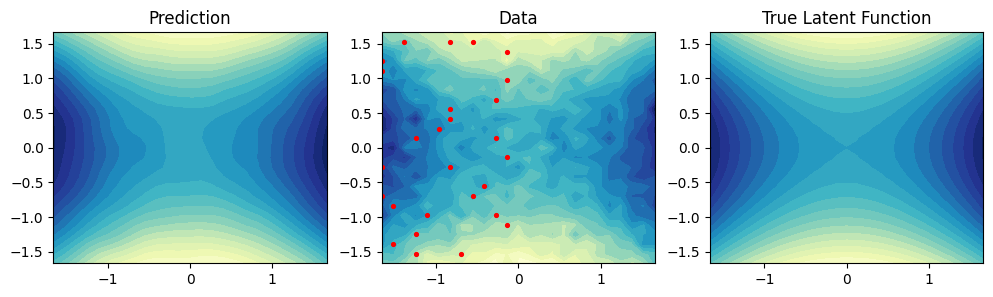

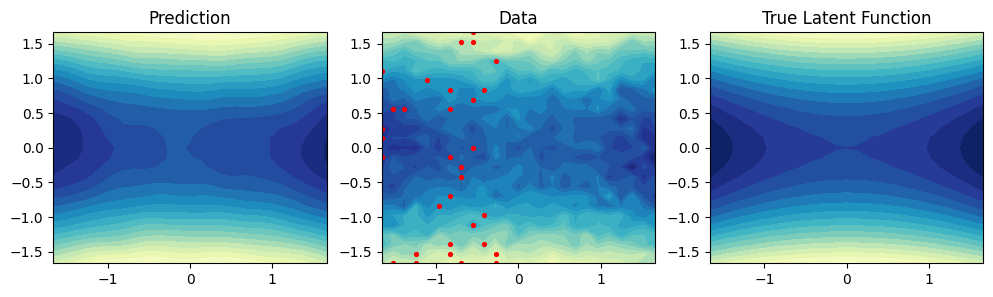

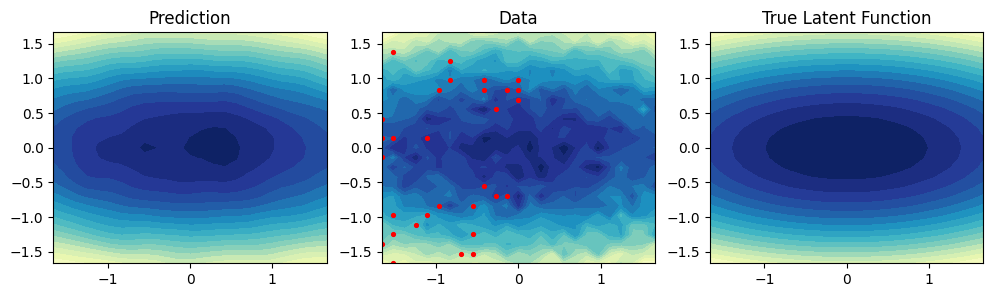

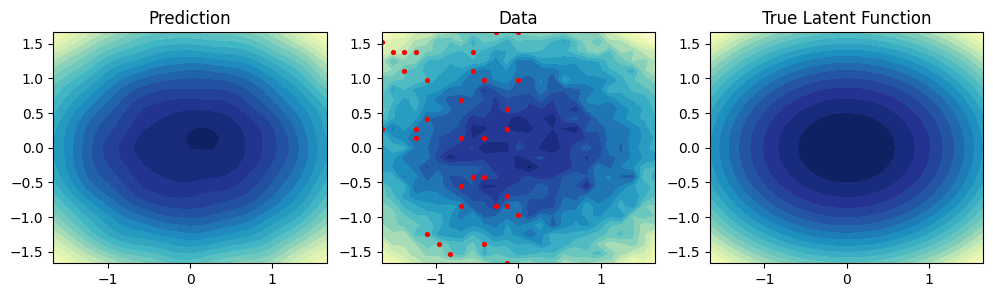

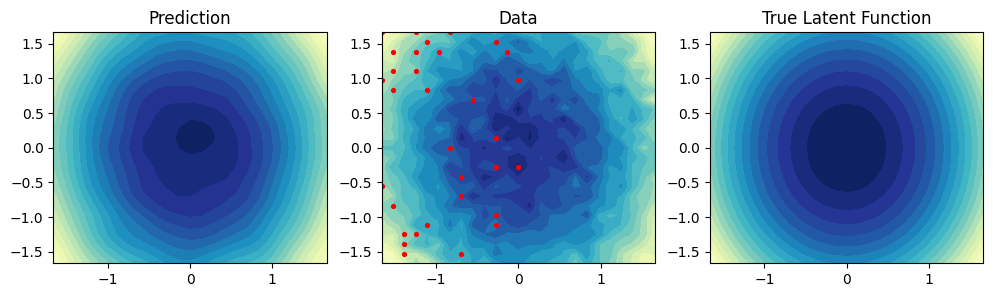

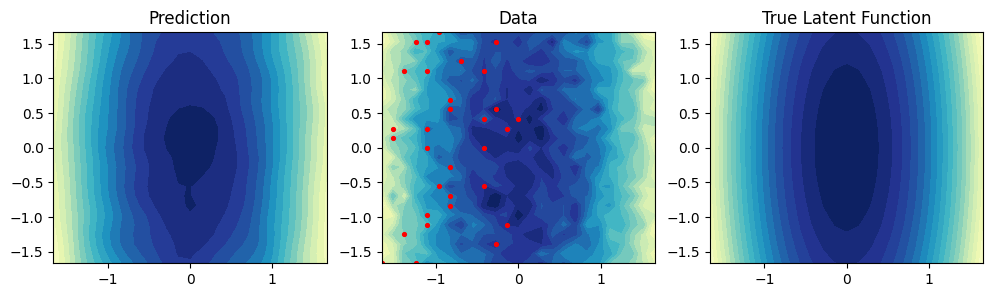

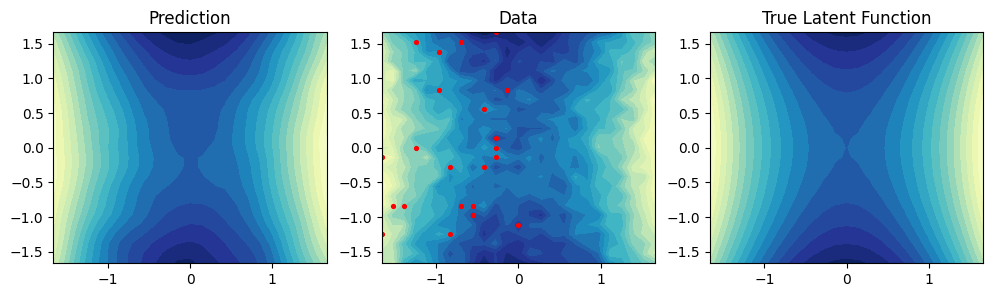

In [15]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

    print("Sum Absolute Diff (pred - true) : ", (tc.abs(preds_smooth - true_Ys.squeeze(-1))).sum(), "\n")

for i in range(10):
    plot(idx=i, grid=grids[0], ts=ts, pred=preds_smooth, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)